## Información no Estructurada
### Máster Universitario en Ciencia de Datos
# Práctica 3.4 &ndash; Recomendación: factorización de matrices y deep learning

### Autores: Óscar Calvet Siso y Enrique Ernesto de Alvear Doñate

Esta práctica tiene por objetivo comprender el diseño de métodos de filtrado colaborativo mediante deep learning como transición desde un modelo bilineal típico de factorización de matrices hacia modelos neuronales de complejidad arbitraria.

El trabajo a realizar se secuencia en los siguiented pasos:
1. Filtrado colaborativo basado en factorización de matrices en NumPy.
2. Repetición del mismo método pero visto como modelo neuronal en TensorFlow o PyTorch (a elegir).
3. Ampliación del modelo introduciendo capas ocultas y/u otras variaciones.

Como punto de partida se plantea en cada caso la formulación de la factorización de matrices más sencilla posible.

Se proporciona gran parte del código; los dos primeros ejercicios consistirán en completar un esqueleto de código, y el tercero queda abierto a la dirección que el estudiante opte por seguir.

## 1.&nbsp; Procesamiento de datos

Se facilita una clase Ratings que se ocupa de las siguientes operaciones:
1. Lectura de datos de rating de un fichero.
2. Preparación de datos en forma de matriz (sin preocuparnos del gasto de RAM: podrían usarse implementaciones sparse matrix para un uso más frugal de RAM y soportar conjuntos de datos más grandes).
3. Binarización de los ratings.
4. Partición de datos en entrenamiento y test.
5. Duplicación redundante de los datos: matriz vs. data frame de ratings de entrenamiento, acorde con diferentes requisitos para diferentes frameworks de implementación (NumPy vs. TensorFlow / PyTorch).

Se hace una implementación simplificada y directa orientada a obtener lo suficiente para los ejercicios de esta práctica, sin buscar más generalidad. Por ejemplo, todas las operaciones (incluida la partición entrenamiento/test) se realizan en el constructor y no se implementan más funciones en la clase que las estrictamente necesarias para los ejercicios y pruebas. Igualmente decidimos trabajar con ratings binarizados.

Se proporcionan una líneas al final de la celda para ilustrar cómo quedan almacenados datos en diferentes subconjuntos y estructuras.

El conjunto de datos `ratings.dat` está disponible en https://grouplens.org/datasets/movielens/1m.

In [ ]:
!wget https://files.grouplens.org/datasets/movielens/ml-1m.zip
!unzip ml-1m.zip
!mv /content/ml-1m/ratings.dat /content/

"wget" no se reconoce como un comando interno o externo,
programa o archivo por lotes ejecutable.


"unzip" no se reconoce como un comando interno o externo,
programa o archivo por lotes ejecutable.
"mv" no se reconoce como un comando interno o externo,
programa o archivo por lotes ejecutable.


In [ ]:
import pandas as pd
import numpy as np

# We cast rating data as 1 for ratings >= threshold (4 by default), and zero for lower vaues or missing ratings.
class Ratings:
    def __init__(self, file, sep=',', split_ratio=.8, threshold=4):
        df = pd.read_csv(file, names=['u', 'i', 'r', 't'], sep=sep, engine='python')
        # Restructure the ratings data into ratings matrix form - and we forget about the original user and item ids: we assign them an incremental int.
        self.ratings_matrix = df.pivot(index='u', columns='i', values='r').fillna(0).to_numpy(dtype=np.float32)
        self.nusers, self.nitems = self.ratings_matrix.shape
        # Split the data already.
        self.split(split_ratio, threshold)

    def split(self, split_ratio, threshold):
        # Split and remember train mask (before binarizing ratings).
        split_mask = np.random.choice([1, 0], p=[split_ratio, 1-split_ratio], size=self.ratings_matrix.shape)
        # With train_mask we remember which are the training ratings, including values below the relevance threshold,
        # since threshold-based binarization will produce zeros for both non-relevant items and missing ratings and
        # we may want to distinguish non-relevant from missing.
        self.train_mask = (self.ratings_matrix > 0) * split_mask
        self.ntrain = self.train_mask.sum()
        # Redundantly copy training into df form for use in Keras and PyTorch.
        self.train_df = matrix_to_df(self.ratings_matrix * split_mask, threshold)
        # Binarize: 1 for relevant above the threshold, 0 for non-relevant below (note: now rating = 0 for both negative and missing user preferences).
        binarized_ratings_matrix = self.ratings_matrix >= threshold
        # Create train & test matrices
        self.train_matrix, self.test_matrix = binarized_ratings_matrix * split_mask, binarized_ratings_matrix * (1 - split_mask)

def matrix_to_df(ratings_matrix, threshold):
    df = pd.DataFrame(columns=np.arange(ratings_matrix.shape[1], dtype=np.int32),
                      index=np.arange(ratings_matrix.shape[0], dtype=np.int32),
                      data=ratings_matrix).unstack().reset_index(name='r')
    df.columns = ['i', 'u', 'r']
    df = df[df.r>0][['u', 'i', 'r']].sort_values(by=['u', 'i'], ignore_index=True)
    df.r = (df.r >= threshold).astype(int)
    return df

# We read the ratings file already - we'll use in the following cells in different MF implementations.
np.random.seed(0) # Seed the random split for comparability and debugging.)
ratings = Ratings('ratings.dat', sep='::', threshold=4)

get_ipython().display_formatter.formatters['text/plain'].for_type(str, lambda s, p, c: p.text(s))

# A small example to get an idea of how the rating data structures are organized.
pd.DataFrame(data=[['u', 'i', 5], ['u', 'j', 3],
                   ['v', 'i', 4], ['v', 'k', 1], ['v', 'l', 5]])\
    .to_csv('toy.csv', index=False, header=False)
toy = Ratings('toy.csv', threshold=4)
display(f'{toy.nusers} users, {toy.nitems} items, {(toy.ratings_matrix > 0).sum()} ratings')
display(f'{toy.ntrain} training ratings, {(toy.ratings_matrix > 0).sum() - toy.ntrain} test ratings')
display('\nAll ratings\n', toy.ratings_matrix)
display('\nTrain mask\n', toy.train_mask)
display('\nBinarized training ratings\n', toy.train_matrix)
display('\nBinarized test ratings\n', toy.test_matrix)
display('\nBinarized training ratings as data frame\n', toy.train_df)

  0%|          | 0/150 [00:30<?, ?epoch/s]


2 users, 4 items, 5 ratings

4 training ratings, 1 test ratings


All ratings


array([[5., 3., 0., 0.],
       [4., 0., 1., 5.]], dtype=float32)


Train mask


array([[1, 1, 0, 0],
       [0, 0, 1, 1]])


Binarized training ratings


array([[1, 0, 0, 0],
       [0, 0, 0, 1]])


Binarized test ratings


array([[0, 0, 0, 0],
       [1, 0, 0, 0]])


Binarized training ratings as data frame


,u,i,r
0,0,0,1
1,0,1,0
2,1,2,0
3,1,3,1


## 2.&nbsp; Métricas y traza de entrenamiento

Se facilitan aquí:
* Dos métricas ya implementadas para evaluar recomendaciones sobre datos de test (usaremos primariamente P@10 pero se puede igualmente probar recall).
* Funciones para visualizar las traza de error de entrenamiento y métricas de test del proceso de entrenamiento.

In [ ]:
import matplotlib.pyplot as pt

# Plot the whole training trace.
def plot(train_errors, test_metrics=None, metric_name=['Precision', 'Test P@10']):
    l1 = pt.plot(range(len(train_errors)), train_errors, linewidth=.7, label='Training cost', c='blue')
    pt.ylabel('MSE')
    pt.xlabel('Epoch')
    if test_metrics:
        ax = pt.gca().twinx()
        l2 = ax.plot(range(len(test_metrics)), test_metrics, linewidth=.7, label=metric_name[1], c='tab:red')
        ax.set_ylabel(metric_name[0])
        pt.legend(l1+l2, [l.get_label() for l in l1+l2])
    else: pt.legend()

# Print train/test error/metric for one epoch.
def trace(epoch, start, train_error, test_metric=None, metric_name=None):
    if test_metric:
        print(f'\rTraining model --> Epochs: {epoch+1}  Training error: {train_error}  Test {metric_name}: {test_metric} \033[94m[{datetime.timedelta(seconds=round(time.time() - start))}]\033[0m', end='                        ')
    else:
        print(f'\rTraining model --> Epochs: {epoch+1}  Training error: {train_error}  \033[94m[{datetime.timedelta(seconds=round(time.time() - start))}]\033[0m', end='                        ')

def precision(score_matrix, test_matrix, cutoff):
    pos = np.sort(np.argpartition(score_matrix, -cutoff)[:, -cutoff:], axis=1)[:, ::-1]
    hits = np.array([t[p[0:min(cutoff, len(p))]] for t, p in zip(test_matrix, pos)])
    return hits.sum() / cutoff / test_matrix.shape[0]

def recall(score_matrix, test_matrix, cutoff):
    pos = np.sort(np.argpartition(score_matrix, -cutoff)[:, -cutoff:], axis=1)[:, ::-1]
    user_relevants = test_matrix.sum(axis=1)
    user_relevants[user_relevants==0] = 1
    hits = np.array([t[p[0:min(cutoff, len(p))]] for t, p in zip(test_matrix, pos)]).sum(axis=1) / user_relevants
    return hits.mean()

## 3.&nbsp; Factorización de matrices: implementación vectorizada

Primera implementación: factorización básica con vectorización en NumPy.

### Ejercicio

Completar los huecos marcados con `# Your code here...`.

Sugerencia: implementar *full batch gradient descent*, es decir utilizar todas las celdas de la matriz de ratings (celdas vacías incluidas a modo de "muestras negativas") como datos de entrenamiento en cada época.

Training model --> Epochs: 250  Training error: 0.014192240071422665  Test P@10: 0.2812086092715232 [0:04:40]                         


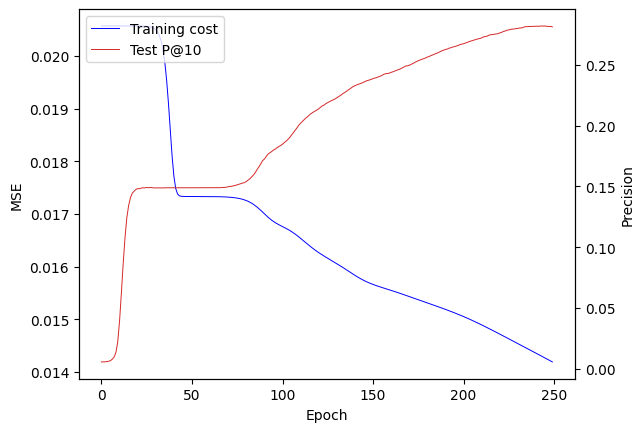

In [ ]:
import time, datetime

# For simplicity, we just train the model as we create the model object. And we keep the rating data as a variable
# in the model object.
class MF():
    def __init__(self, ratings, k=50, lrate=.001, nepochs=250, test_tracking=True, lambda_ = 0.0):
        self.ratings = ratings
        self.test_tracking = test_tracking
        self.lambda_ = lambda_
        self.train(k, lrate, nepochs)


    # The scoring function.
    def predict(self):
        return self.user_mat @ self.item_mat.T #Se multiplica la matriz de usuarios por la de items

    # Initialize the model parameters.
    def init(self, k):#Vamos a inicializar de forma aleatoria las matrices de usuarios e items
      self.user_mat = np.random.normal(scale = 1/self.ratings.nusers ,size=(self.ratings.nusers, k))
      self.item_mat = np.random.normal(scale = 1/self.ratings.nitems ,size=(self.ratings.nitems,k))
      self.scores_ = self.predict() #Calculamos los scores


    # Train the model (learn the model parameters).
    def train(self, k, lrate, nepochs):
        start_time = time.time()
        self.init(k)
        self.train_errors, self.test_metrics = [], []

        # Training loop.
        for epoch in range(nepochs):
            # Gradient descent steps: model parameters' update.
            # Your code here... (hint: can be done in 3-4 lines).
            err = self.ratings.train_matrix - self.scores_
            grad_item, grad_user = err.T @ self.user_mat, err @ self.item_mat
            #que hacemos con lambda
            self.user_mat += lrate*(grad_user - self.lambda_ * self.user_mat)
            self.item_mat += lrate*(grad_item - self.lambda_ * self.item_mat)
            # Produce training trace for inspection.
            train_error = (err**2).mean()
            self.train_errors.append(train_error)
            # We make precision tracking optional as it can be time-consuming.
            self.scores_ = self.predict()
            if self.test_tracking:
                test_metric = precision(self.scores(), self.ratings.test_matrix, 10)
                self.test_metrics.append(test_metric)
                trace(epoch, start_time, train_error, test_metric, 'P@10')
            else: trace(epoch, start_time, train_error)
        print()

        # If we're not tracking test metrics at least we report it at the end.
        if not self.test_tracking: trace(epoch, start_time, train_error,
                                         precision(self.scores(), self.ratings.test_matrix, 10), 'P@10')

    # Warning: you don't need to use this function -- it's used only for computing precision on test data.
    # Just remove from the prediction scores the matrix cells where there is a training rating: we assume
    # we don't want to recommend stuff the user has already rated, as is most often the case in recommender
    # system applications.
    def scores(self): return self.scores_ * (1 - ratings.train_mask)

# Create the model - this will directly trigger training.
np.random.seed(0) # For comparability and debugging (the randomness here is in parameter initialization).
mf = MF(ratings, lrate=.001, nepochs=250)

# Plot the training error and test metric trace.
plot(mf.train_errors, mf.test_metrics)

## 4.&nbsp; Factorización de matrices: modelo deep learning &ndash; opción a) TensorFlow

Reformulación de la factorización de matrices como caso particular "degenerado" de arquitectura neuronal.

### Ejercicio

Completar los huecos marcados con `# Your code here...`.

Observaciones:
* Por la estructura de datos de entrenamiento que maneja TensorFlow, entrenar con toda la matriz de ratings (incluyendo todas las celdas sin dato) es demasiado costoso. Por ello se tomará una muestra pequeña de ejemlos negativos en cada época.
* En el esqueleto que aquí se proporciona, no se genera la traza (curva) de P@10 durante el entrenamiento ya que no encaja fácilmente en el API Keras de TensorFlow.

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None,)]                    0         []                            
                                                                                                  
 input_6 (InputLayer)        [(None,)]                    0         []                            
                                                                                                  
 embedding_4 (Embedding)     (None, 50)                   302000    ['input_5[0][0]']             
                                                                                                  
 embedding_5 (Embedding)     (None, 50)                   185300    ['input_6[0][0]']             
                                                                                            

100%|██████████| 150/150 [05:11<00:00,  2.08s/epoch, loss=0.0559]


38/38 [==============================] - 4s 76ms/step
Training model --> Epochs: 151  Training error: 0.055914804339408875  Test P@10: 0.23314569536423843 [0:05:20]                        

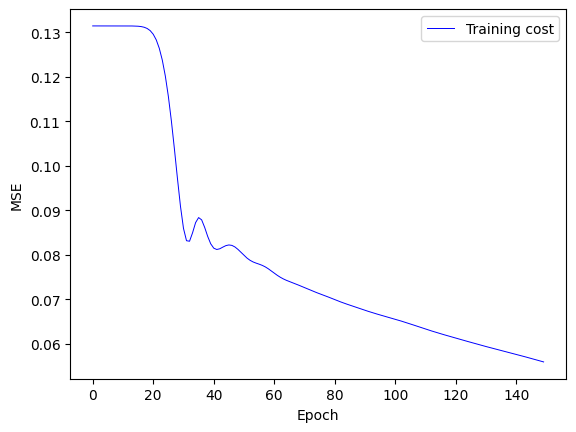

In [ ]:
import tensorflow as tf
from tqdm.keras import TqdmCallback
import time, datetime, IPython

# See the file 'tf-model.png' that was generated with a solution to this exercise - when you run
# your own implementation, you will get your own plot.
def create_model(k=50, lrate=.01, neg=4, nepochs=150):
    # 'users' is an input layer of type tf.int64.
    users = tf.keras.layers.Input(shape = (), dtype = tf.int64)
    user_embeddings = tf.keras.layers.Embedding(ratings.nusers, k, embeddings_initializer = tf.keras.initializers.RandomNormal(stddev = 1/ratings.nusers))(users)
    # 'items' is an input layer of type tf.int64.
    items = tf.keras.layers.Input(shape = (), dtype = tf.int64)
    item_embeddings = tf.keras.layers.Embedding(ratings.nitems, k, embeddings_initializer = tf.keras.initializers.RandomNormal(stddev = 1/ratings.nitems))(items)
    # TensorFlow has a built-in dot-product layer.
    dot = tf.keras.layers.Dot(axes = 1)([user_embeddings, item_embeddings])
    # Now we need a generic model that wraps up the "network", specifying the input and output layers.
    tf_mf = tf.keras.Model(inputs = [users, items], outputs = dot)
    # Compile the model: Adam optimizer is suggested here over SGD.
    # Your code here...
    tf_mf.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = lrate), loss = "MSE")

    # Show the model topology - a plot will be produced in a file 'tf-model.png'.
    tf_mf.summary()
    tf.keras.utils.plot_model(tf_mf, to_file='tf-model.png', show_shapes=True, dpi=150)

    hist = train_model(tf_mf, neg, nepochs)
    return tf_mf, hist

def train_model(tf_mf, neg, nepochs):
    # We inject 'neg' negative samples for every available rating in the training data
    nneg = neg * ratings.ntrain
    users = np.concatenate((ratings.train_df.u, np.random.randint(ratings.nusers, size=nneg)))
    items = np.concatenate((ratings.train_df.i, np.random.randint(ratings.nitems, size=nneg)))
    rs = ratings.train_matrix[users, items]
    batch_size = ratings.ntrain + nneg # Single batch with all the data at once.

    hist = tf_mf.fit([users, items], rs, batch_size = batch_size, epochs = nepochs, callbacks=[TqdmCallback(verbose=0)], verbose = 0) # Produces a prettier progress bar.
    return hist

# Create the model - this will directly trigger training.
tf.random.set_seed(0) # For comparability and debugging (the randomness here is in parameter initialization).
start_time = time.time()
tf_mf, hist = create_model(k=50, lrate=.01, nepochs=150)

# Plot the training error and report the test metric value (P@10).

plot(hist.history['loss'])

uexplode = np.full((ratings.nitems, ratings.nusers), np.arange(ratings.nusers)).T.flatten()
iexplode = np.full((ratings.nusers, ratings.nitems), np.arange(ratings.nitems)).flatten()
scores = tf_mf.predict([uexplode, iexplode], batch_size=ratings.nusers*100,
                       verbose=1).reshape(ratings.nusers, ratings.nitems)
p = precision(scores*(1-ratings.train_mask), ratings.test_matrix, 10)
trace(hist.params['epochs'], start_time, hist.history['loss'][-1], p, 'P@10')

## 4.&nbsp; Factorización de matrices: modelo deep learning &ndash; opción b) PyTorch

Reformulación de la factorización de matrices como caso particular "degenerado" de arquitectura neuronal.

### Ejercicio

Completar los huecos marcados con `# Your code here...`.

Observaciones:
* Por motivos de la estructura de datos de entrenamiento que maneja PyTorch, entrenar con toda la matriz de ratings es demasiado costoso. Por ello se tomará una muestra pequeña de ejemlos negativos en cada época.
* En el esqueñeto que aquí se facilita sí se genera la traza (curva) de P@10 durante el entrenamiento, ya que el profesor ha encontrado un "bypass" razonable para hacerlo sin excesiva ralentización del entrenamiento.

In [ ]:
# import torch
# from torch import nn
# import torch.nn.functional as F
# from matplotlib import pyplot as plt
# from torchviz import make_dot
# import time, datetime

# # Different from TensorFlow, PyTorch doesn't have a Dot layer, so we have to implement it ourselves.
# # You can check out a plot of the model topology in file 'torch-model.png' generated with a solution to this
# # exercise - when you run your own implementation, you will get your own plot.
# class Dot(torch.nn.Module):
#     def __init__(self, ratings, k=50, lr=.01, neg=4, nepochs=150, test_tracking=False):
#         super().__init__()
#         self.ratings = ratings
#         self.lr = lr
#         self.neg = neg
#         self.nepochs = nepochs
#         self.test_tracking = test_tracking

#         self.user_embeddings = # Your code here...
#         self.item_embeddings = # Your code here...
#         self.train()

#     def forward(self, users, items):
#         return # Your code here... (hint: can be done in one line).

#     # Initialize the embeddings layers.
#     def init(self):
#         # Your code here...

#     def train(self):
#         start_time = time.time()
#         loss_fn = # Your code here...
#         # Adam optimizer is suggested here over SGD.
#         optimizer = # Your code here...
#         self.init()

#         self.train_errors, self.test_metrics = [], []
#         for epoch in range(self.nepochs):
#             optimizer.zero_grad()

#             # We inject 'neg' negative samples for every available rating in the training data.
#             nneg = self.neg * self.ratings.ntrain
#             users = np.concatenate((self.ratings.train_df.u, np.random.randint(self.ratings.nusers, size=nneg)))
#             items = np.concatenate((self.ratings.train_df.i, np.random.randint(self.ratings.nitems, size=nneg)))
#             rs = torch.tensor(self.ratings.train_matrix[users, items], dtype=torch.float32)

#             # Call the loss function on users, items, rs.
#             loss = # Your code here...

#             # Backprop + optimization step
#             # Your code here...

#             # Produce training trace for inspection.
#             self.train_errors.append(loss.item())
#             # We make precision tracking optional as it is time-consuming.
#             if self.test_tracking:
#                 test_metric = precision(self.scores_matrix() * (1-ratings.train_mask), self.ratings.test_matrix, 10)
#                 self.test_metrics.append(test_metric)
#                 trace(epoch, start_time, loss.item(), test_metric, 'P@10')
#             else: trace(epoch, start_time, loss.item())
#         print()
#         # If we're not tracking test metrics at least we report it at the end.
#         if not self.test_tracking: trace(epoch, start_time, train_error,
#                                          precision(self.scores_matrix() * (1-ratings.train_mask), self.ratings.test_matrix, 10), 'P@10')

#     # Warning: do not call this function.
#     # It is just intended to compute test metrics fast by computing the full score matrix at every epoch, bypassing the forward method.
#     # The speed difference is dramatic because ranking metric computaiton requires the entire ragings matrix, while forward takes uids
#     # and iids in record format and involves a crazy spend of memory and compute time.
#     # Detach bacause we don't want gradient tracking here.
#     def scores_matrix(self): return (self.user_embeddings.weight @ self.item_embeddings.weight.T).detach()

# # Create the model - this will directly trigger training.
# torch.manual_seed(0) # For comparability and debugging (the randomness here is in parameter initialization).
# torch_mf = Dot(ratings, lr=.01, neg=4, k=50, nepochs=150, test_tracking=True)

# # Plot the training error and test metric trace.
# plot(torch_mf.train_errors, torch_mf.test_metrics)

# # Show the model topology
# make_dot(torch_mf([0, 0], [1, 2]))

## 5.&nbsp; Ampliación

### Ejercicio

Explorar variaciones sobre una o varias de las implementaciones anteriores, tales como:
* Diferentes funciones de scoring pérdida: sigmoide / BCE loss, BCE loss with logits. <---
* Diferentes optimizadores y configuraciones de los mismos (SGD, Adam, etc.). <---
* Variaciones en los hiperparámetros y configuración del modelo: learning rate, número de factores k, número de épocas, inicialización de parámetros del modelo, etc. <---
* Muestreo negativo: diferente número de ejemplos negativos.
* Añadir opciones tales como regularización, dropout, etc. <-----
* Variaciones del modelo: términos de bias (usuario/item/global), ponderaciones de datos (p.e. ver modelo sencillo "*confidence weight*" de Hu, Koren & Volinsky), etc.
* Añadir capas ocultas en la implementación sobre framework de deep learning. <-----
* Explorar una formulación *pairwise learning to rank* sobre MF (p.e. BPR).
* Probar otros modelos de factorización de matrices.

Idealmente estas variaciones buscan mejorar la precisión de la recomendación, pero se valorarán intentos interesantes aunque resulten fallidos en ese aspecto.

**Uso de otro optimizador**

c:\Users\ENRIQ\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None,)]                    0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None,)]                    0         []                            
                                                                                                  
 embedding (Embedding)       (None, 50)                   302000    ['input_1[0][0]']             
                                                                                                  
 embedding_1 (Embedding)     (None, 50)                   185300    ['input_2[0][0]']             
                                                                                              

100%|██████████| 150/150 [02:50<00:00,  1.14s/epoch, loss=0.131]


38/38 [==============================] - 2s 39ms/step
Training model --> Epochs: 151  Training error: 0.13137541711330414  Test P@10: 0.005298013245033113 [0:02:54]                        

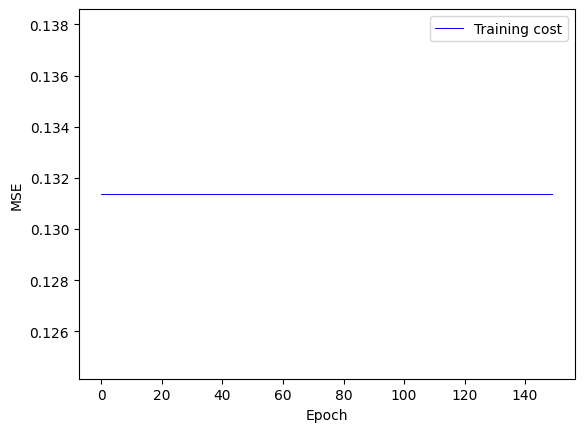

In [ ]:
import tensorflow as tf
from tqdm.keras import TqdmCallback
import time, datetime, IPython

# See the file 'tf-model.png' that was generated with a solution to this exercise - when you run
# your own implementation, you will get your own plot.
def create_model(k=50, lrate=.01, neg=4, nepochs=150):
    # 'users' is an input layer of type tf.int64.
    users = tf.keras.layers.Input(shape = (), dtype = tf.int64)
    user_embeddings = tf.keras.layers.Embedding(ratings.nusers, k, embeddings_initializer = tf.keras.initializers.RandomNormal(stddev = 1/ratings.nusers))(users) # Your code here...
    # 'items' is an input layer of type tf.int64.
    items = tf.keras.layers.Input(shape = (), dtype = tf.int64)
    item_embeddings = tf.keras.layers.Embedding(ratings.nitems, k, embeddings_initializer = tf.keras.initializers.RandomNormal(stddev = 1/ratings.nitems))(items)
    # TensorFlow has a built-in dot-product layer.
    dot = tf.keras.layers.Dot(axes = 1)([user_embeddings, item_embeddings])
    # Now we need a generic model that wraps up the "network", specifying the input and output layers.
    tf_mf = tf.keras.Model(inputs = [users, items], outputs = dot)
    # Compile the model: Adam optimizer is suggested here over SGD.
    # Your code here...
    tf_mf.compile(optimizer = tf.keras.optimizers.SGD(learning_rate = lrate), loss = "MSE")

    # Show the model topology - a plot will be produced in a file 'tf-model.png'.
    tf_mf.summary()
    tf.keras.utils.plot_model(tf_mf, to_file='tf-model.png', show_shapes=True, dpi=150)

    hist = train_model(tf_mf, neg, nepochs)
    return tf_mf, hist

def train_model(tf_mf, neg, nepochs):
    # We inject 'neg' negative samples for every available rating in the training data
    nneg = neg * ratings.ntrain
    users = np.concatenate((ratings.train_df.u, np.random.randint(ratings.nusers, size=nneg)))
    items = np.concatenate((ratings.train_df.i, np.random.randint(ratings.nitems, size=nneg)))
    rs = ratings.train_matrix[users, items]
    batch_size = ratings.ntrain + nneg # Single batch with all the data at once.

    hist = tf_mf.fit([users, items], rs, batch_size = batch_size, epochs = nepochs, callbacks=[TqdmCallback(verbose=0)], verbose = 0) # Produces a prettier progress bar.
    return hist

# Create the model - this will directly trigger training.
tf.random.set_seed(0) # For comparability and debugging (the randomness here is in parameter initialization).
start_time = time.time()
tf_mf, hist = create_model(k=50, lrate=.01, nepochs=150)

# Plot the training error and report the test metric value (P@10).

plot(hist.history['loss'])

uexplode = np.full((ratings.nitems, ratings.nusers), np.arange(ratings.nusers)).T.flatten()
iexplode = np.full((ratings.nusers, ratings.nitems), np.arange(ratings.nitems)).flatten()
scores = tf_mf.predict([uexplode, iexplode], batch_size=ratings.nusers*100,
                       verbose=1).reshape(ratings.nusers, ratings.nitems)
p = precision(scores*(1-ratings.train_mask), ratings.test_matrix, 10)
trace(hist.params['epochs'], start_time, hist.history['loss'][-1], p, 'P@10')

Se ha cambiado el optimizador a SGD, de lo que se puede ver que realmente el optimizador Adam del código original es mejor.

**Cambio de la función de pérdida a BCE**

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None,)]                    0         []                            
                                                                                                  
 input_4 (InputLayer)        [(None,)]                    0         []                            
                                                                                                  
 embedding_2 (Embedding)     (None, 50)                   302000    ['input_3[0][0]']             
                                                                                                  
 embedding_3 (Embedding)     (None, 50)                   185300    ['input_4[0][0]']             
                                                                                            

100%|██████████| 150/150 [02:52<00:00,  1.15s/epoch, loss=0.256]


38/38 [==============================] - 2s 42ms/step
Training model --> Epochs: 151  Training error: 0.2560540437698364  Test P@10: 0.09938741721854304 [0:02:55]                        

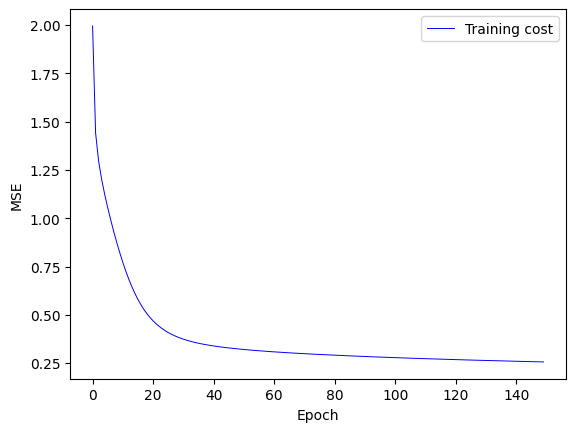

In [ ]:
import tensorflow as tf
from tqdm.keras import TqdmCallback
import time, datetime, IPython

# See the file 'tf-model.png' that was generated with a solution to this exercise - when you run
# your own implementation, you will get your own plot.
def create_model(k=50, lrate=.01, neg=4, nepochs=150):
    # 'users' is an input layer of type tf.int64.
    users = tf.keras.layers.Input(shape = (), dtype = tf.int64)
    user_embeddings = tf.keras.layers.Embedding(ratings.nusers, k, embeddings_initializer = tf.keras.initializers.RandomNormal(stddev = 1/ratings.nusers))(users) # Your code here...
    # 'items' is an input layer of type tf.int64.
    items = tf.keras.layers.Input(shape = (), dtype = tf.int64)
    item_embeddings = tf.keras.layers.Embedding(ratings.nitems, k, embeddings_initializer = tf.keras.initializers.RandomNormal(stddev = 1/ratings.nitems))(items)
    # TensorFlow has a built-in dot-product layer.
    dot = tf.keras.layers.Dot(axes = 1)([user_embeddings, item_embeddings])
    # Now we need a generic model that wraps up the "network", specifying the input and output layers.
    tf_mf = tf.keras.Model(inputs = [users, items], outputs = dot)
    # Compile the model: Adam optimizer is suggested here over SGD.
    # Your code here...
    tf_mf.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = lrate), loss = "binary_crossentropy")

    # Show the model topology - a plot will be produced in a file 'tf-model.png'.
    tf_mf.summary()
    tf.keras.utils.plot_model(tf_mf, to_file='tf-model.png', show_shapes=True, dpi=150)

    hist = train_model(tf_mf, neg, nepochs)
    return tf_mf, hist

def train_model(tf_mf, neg, nepochs):
    # We inject 'neg' negative samples for every available rating in the training data
    nneg = neg * ratings.ntrain
    users = np.concatenate((ratings.train_df.u, np.random.randint(ratings.nusers, size=nneg)))
    items = np.concatenate((ratings.train_df.i, np.random.randint(ratings.nitems, size=nneg)))
    rs = ratings.train_matrix[users, items]
    batch_size = ratings.ntrain + nneg # Single batch with all the data at once.

    hist = tf_mf.fit([users, items], rs, batch_size = batch_size, epochs = nepochs, callbacks=[TqdmCallback(verbose=0)], verbose = 0) # Produces a prettier progress bar.
    return hist

# Create the model - this will directly trigger training.
tf.random.set_seed(0) # For comparability and debugging (the randomness here is in parameter initialization).
start_time = time.time()
tf_mf, hist = create_model(k=50, lrate=.01, nepochs=150)

# Plot the training error and report the test metric value (P@10).

plot(hist.history['loss'])

uexplode = np.full((ratings.nitems, ratings.nusers), np.arange(ratings.nusers)).T.flatten()
iexplode = np.full((ratings.nusers, ratings.nitems), np.arange(ratings.nitems)).flatten()
scores = tf_mf.predict([uexplode, iexplode], batch_size=ratings.nusers*100,
                       verbose=1).reshape(ratings.nusers, ratings.nitems)
p = precision(scores*(1-ratings.train_mask), ratings.test_matrix, 10)
trace(hist.params['epochs'], start_time, hist.history['loss'][-1], p, 'P@10')

Se ha probado a cambiar la función de pérdida a BCE no obteniendo mejores resultados

**Utilizando la función de pérdida BCE con logits**

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_9 (InputLayer)        [(None,)]                    0         []                            
                                                                                                  
 input_10 (InputLayer)       [(None,)]                    0         []                            
                                                                                                  
 embedding_8 (Embedding)     (None, 50)                   302000    ['input_9[0][0]']             
                                                                                                  
 embedding_9 (Embedding)     (None, 50)                   185300    ['input_10[0][0]']            
                                                                                            

100%|██████████| 100/100 [01:51<00:00,  1.11s/epoch, loss=0.257]


38/38 [==============================] - 2s 42ms/step
Training model --> Epochs: 101  Training error: 0.257344514131546  Test P@10: 0.13422185430463576 [0:01:54]                        

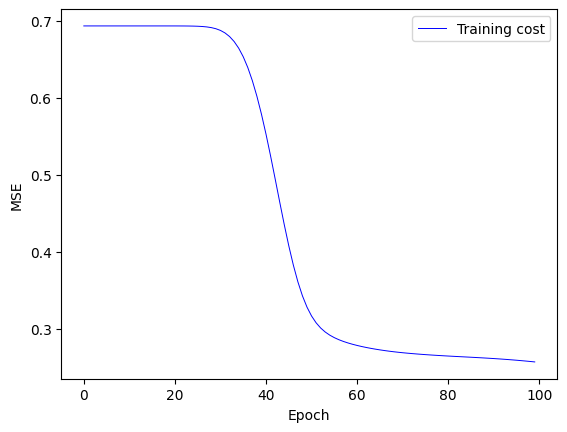

In [ ]:
import tensorflow as tf
from tqdm.keras import TqdmCallback
import time, datetime, IPython

# See the file 'tf-model.png' that was generated with a solution to this exercise - when you run
# your own implementation, you will get your own plot.
def create_model(k=50, lrate=.01, neg=4, nepochs=150):
    # 'users' is an input layer of type tf.int64.
    users = tf.keras.layers.Input(shape = (), dtype = tf.int64)
    user_embeddings = tf.keras.layers.Embedding(ratings.nusers, k, embeddings_initializer = tf.keras.initializers.RandomNormal(stddev = 1/ratings.nusers))(users) # Your code here...
    # 'items' is an input layer of type tf.int64.
    items = tf.keras.layers.Input(shape = (), dtype = tf.int64)
    item_embeddings = tf.keras.layers.Embedding(ratings.nitems, k, embeddings_initializer = tf.keras.initializers.RandomNormal(stddev = 1/ratings.nitems))(items)
    # TensorFlow has a built-in dot-product layer.
    dot = tf.keras.layers.Dot(axes = 1)([user_embeddings, item_embeddings])
    # Now we need a generic model that wraps up the "network", specifying the input and output layers.
    tf_mf = tf.keras.Model(inputs = [users, items], outputs = dot)
    # Compile the model: Adam optimizer is suggested here over SGD.
    # Your code here...
    tf_mf.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = lrate), loss = tf.keras.losses.BinaryCrossentropy(from_logits= True))

    # Show the model topology - a plot will be produced in a file 'tf-model.png'.
    tf_mf.summary()
    tf.keras.utils.plot_model(tf_mf, to_file='tf-model.png', show_shapes=True, dpi=150)

    hist = train_model(tf_mf, neg, nepochs)
    return tf_mf, hist

def train_model(tf_mf, neg, nepochs):
    # We inject 'neg' negative samples for every available rating in the training data
    nneg = neg * ratings.ntrain
    users = np.concatenate((ratings.train_df.u, np.random.randint(ratings.nusers, size=nneg)))
    items = np.concatenate((ratings.train_df.i, np.random.randint(ratings.nitems, size=nneg)))
    rs = ratings.train_matrix[users, items]
    batch_size = ratings.ntrain + nneg # Single batch with all the data at once.

    hist = tf_mf.fit([users, items], rs, batch_size = batch_size, epochs = nepochs, callbacks=[TqdmCallback(verbose=0)], verbose = 0) # Produces a prettier progress bar.
    return hist

# Create the model - this will directly trigger training.
tf.random.set_seed(0) # For comparability and debugging (the randomness here is in parameter initialization).
start_time = time.time()
tf_mf, hist = create_model(k=50, lrate=.01, nepochs=100)

# Plot the training error and report the test metric value (P@10).

plot(hist.history['loss'])

uexplode = np.full((ratings.nitems, ratings.nusers), np.arange(ratings.nusers)).T.flatten()
iexplode = np.full((ratings.nusers, ratings.nitems), np.arange(ratings.nitems)).flatten()
scores = tf_mf.predict([uexplode, iexplode], batch_size=ratings.nusers*100,
                       verbose=1).reshape(ratings.nusers, ratings.nitems)
p = precision(scores*(1-ratings.train_mask), ratings.test_matrix, 10)
trace(hist.params['epochs'], start_time, hist.history['loss'][-1], p, 'P@10')

En cambio se puede ver que BCE con logits mejora ligeramente los resultados obtenidos con BCE, pero sigue sin llegar al nivel de precisión del MSE

**Añadiendo capas densas y dropout**

Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_25 (InputLayer)       [(None,)]                    0         []                            
                                                                                                  
 input_26 (InputLayer)       [(None,)]                    0         []                            
                                                                                                  
 embedding_24 (Embedding)    (None, 50)                   302000    ['input_25[0][0]']            
                                                                                                  
 embedding_25 (Embedding)    (None, 50)                   185300    ['input_26[0][0]']            
                                                                                           

100%|██████████| 150/150 [03:36<00:00,  1.45s/epoch, loss=0.059] 


38/38 [==============================] - 3s 66ms/step
Training model --> Epochs: 151  Training error: 0.05897965654730797  Test P@10: 0.21937086092715233 [0:03:41]                        

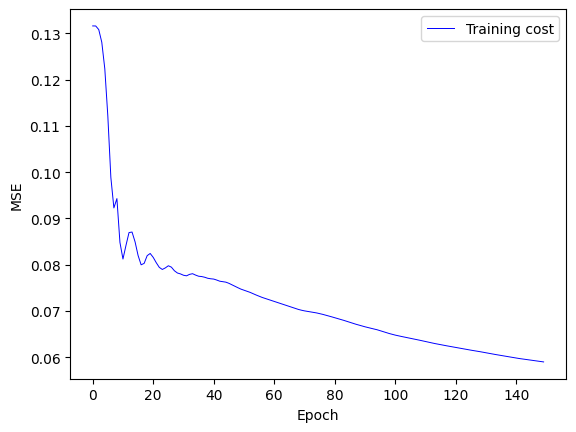

In [ ]:
import tensorflow as tf
from tqdm.keras import TqdmCallback
import time, datetime, IPython

# See the file 'tf-model.png' that was generated with a solution to this exercise - when you run
# your own implementation, you will get your own plot.
def create_model(k=50, lrate=.01, neg=4, nepochs=150):
    # 'users' is an input layer of type tf.int64.
    users = tf.keras.layers.Input(shape = (), dtype = tf.int64)
    user_embeddings = tf.keras.layers.Embedding(ratings.nusers, k, embeddings_initializer = tf.keras.initializers.RandomNormal(stddev = 1/ratings.nusers))(users) # Your code here...
    #user_drop = tf.keras.layers.Dropout(0.2)(user_embeddings)
    #users_dense = tf.keras.layers.Dense(30, activation = "relu", kernel_regularizer="l2")(user_drop)
    users_dense = tf.keras.layers.Dense(int(k*0.9), activation = "linear")(user_embeddings)


    # 'items' is an input layer of type tf.int64.
    items = tf.keras.layers.Input(shape = (), dtype = tf.int64)
    item_embeddings = tf.keras.layers.Embedding(ratings.nitems, k, embeddings_initializer = tf.keras.initializers.RandomNormal(stddev = 1/ratings.nitems))(items)
    #item_drop = tf.keras.layers.Dropout(0.2)(item_embeddings)
    #items_dense = tf.keras.layers.Dense(30, activation = "relu", kernel_regularizer="l2")(item_drop)
    items_dense = tf.keras.layers.Dense(int(k*0.9), activation = "linear")(item_embeddings)
    # TensorFlow has a built-in dot-product layer.
    dot = tf.keras.layers.Dot(axes = 1)([users_dense, items_dense])
    # Now we need a generic model that wraps up the "network", specifying the input and output layers.
    tf_mf = tf.keras.Model(inputs = [users, items], outputs = dot)
    # Compile the model: Adam optimizer is suggested here over SGD.
    # Your code here...
    tf_mf.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = lrate), loss = "MSE")

    # Show the model topology - a plot will be produced in a file 'tf-model.png'.
    tf_mf.summary()
    tf.keras.utils.plot_model(tf_mf, to_file='tf-model.png', show_shapes=True, dpi=150)

    hist = train_model(tf_mf, neg, nepochs)
    return tf_mf, hist

def train_model(tf_mf, neg, nepochs):
    # We inject 'neg' negative samples for every available rating in the training data
    nneg = neg * ratings.ntrain
    users = np.concatenate((ratings.train_df.u, np.random.randint(ratings.nusers, size=nneg)))
    items = np.concatenate((ratings.train_df.i, np.random.randint(ratings.nitems, size=nneg)))
    rs = ratings.train_matrix[users, items]
    batch_size = ratings.ntrain + nneg # Single batch with all the data at once.

    hist = tf_mf.fit([users, items], rs, batch_size = batch_size, epochs = nepochs, callbacks=[TqdmCallback(verbose=0)], verbose = 0) # Produces a prettier progress bar.
    return hist

# Create the model - this will directly trigger training.
tf.random.set_seed(0) # For comparability and debugging (the randomness here is in parameter initialization).
start_time = time.time()
tf_mf, hist = create_model(k=50, lrate=.01, nepochs=150)

# Plot the training error and report the test metric value (P@10).

plot(hist.history['loss'])

uexplode = np.full((ratings.nitems, ratings.nusers), np.arange(ratings.nusers)).T.flatten()
iexplode = np.full((ratings.nusers, ratings.nitems), np.arange(ratings.nitems)).flatten()
scores = tf_mf.predict([uexplode, iexplode], batch_size=ratings.nusers*100,
                       verbose=1).reshape(ratings.nusers, ratings.nitems)
p = precision(scores*(1-ratings.train_mask), ratings.test_matrix, 10)
trace(hist.params['epochs'], start_time, hist.history['loss'][-1], p, 'P@10')

Añadiendo una capa densa antes del dot product en cada una de las torres se pueden obtener resultados bastante parecidos en precisión respecto al primer intento, pero, lo interesante de este es que el error de entrenamiento baja de forma más rápida, por lo que se podría decir que es un mejor modelo, ya que con un menor número de épocas podría llegar al mismo MSE.

**Cambiando hiperparámetros como el learning rate**

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_13 (InputLayer)       [(None,)]                    0         []                            
                                                                                                  
 input_14 (InputLayer)       [(None,)]                    0         []                            
                                                                                                  
 embedding_12 (Embedding)    (None, 50)                   302000    ['input_13[0][0]']            
                                                                                                  
 embedding_13 (Embedding)    (None, 50)                   185300    ['input_14[0][0]']            
                                                                                            

100%|██████████| 150/150 [02:37<00:00,  1.05s/epoch, loss=0.0654]


38/38 [==============================] - 2s 39ms/step
Training model --> Epochs: 151  Training error: 0.06536974757909775  Test P@10: 0.2129304635761589 [0:02:40]                        

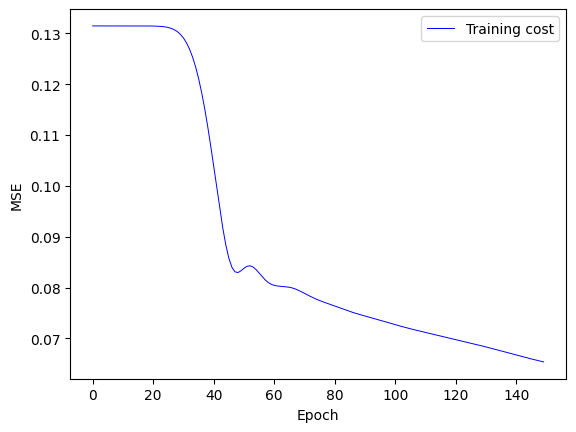

In [ ]:
import tensorflow as tf
from tqdm.keras import TqdmCallback
import time, datetime, IPython

# See the file 'tf-model.png' that was generated with a solution to this exercise - when you run
# your own implementation, you will get your own plot.
def create_model(k=50, lrate=.01, neg=4, nepochs=150):
    # 'users' is an input layer of type tf.int64.
    users = tf.keras.layers.Input(shape = (), dtype = tf.int64)
    user_embeddings = tf.keras.layers.Embedding(ratings.nusers, k, embeddings_initializer = tf.keras.initializers.RandomNormal(stddev = 1/ratings.nusers))(users) # Your code here...
    # 'items' is an input layer of type tf.int64.
    items = tf.keras.layers.Input(shape = (), dtype = tf.int64)
    item_embeddings = tf.keras.layers.Embedding(ratings.nitems, k, embeddings_initializer = tf.keras.initializers.RandomNormal(stddev = 1/ratings.nitems))(items)
    # TensorFlow has a built-in dot-product layer.
    dot = tf.keras.layers.Dot(axes = 1)([user_embeddings, item_embeddings])
    # Now we need a generic model that wraps up the "network", specifying the input and output layers.
    tf_mf = tf.keras.Model(inputs = [users, items], outputs = dot)
    # Compile the model: Adam optimizer is suggested here over SGD.
    # Your code here...
    tf_mf.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = lrate), loss = "MSE")

    # Show the model topology - a plot will be produced in a file 'tf-model.png'.
    tf_mf.summary()
    tf.keras.utils.plot_model(tf_mf, to_file='tf-model.png', show_shapes=True, dpi=150)

    hist = train_model(tf_mf, neg, nepochs)
    return tf_mf, hist

def train_model(tf_mf, neg, nepochs):
    # We inject 'neg' negative samples for every available rating in the training data
    nneg = neg * ratings.ntrain
    users = np.concatenate((ratings.train_df.u, np.random.randint(ratings.nusers, size=nneg)))
    items = np.concatenate((ratings.train_df.i, np.random.randint(ratings.nitems, size=nneg)))
    rs = ratings.train_matrix[users, items]
    batch_size = ratings.ntrain + nneg # Single batch with all the data at once.

    hist = tf_mf.fit([users, items], rs, batch_size = batch_size, epochs = nepochs, callbacks=[TqdmCallback(verbose=0)], verbose = 0) # Produces a prettier progress bar.
    return hist

# Create the model - this will directly trigger training.
tf.random.set_seed(0) # For comparability and debugging (the randomness here is in parameter initialization).
start_time = time.time()
tf_mf, hist = create_model(k=50, lrate=.005, nepochs=150)

# Plot the training error and report the test metric value (P@10).

plot(hist.history['loss'])

uexplode = np.full((ratings.nitems, ratings.nusers), np.arange(ratings.nusers)).T.flatten()
iexplode = np.full((ratings.nusers, ratings.nitems), np.arange(ratings.nitems)).flatten()
scores = tf_mf.predict([uexplode, iexplode], batch_size=ratings.nusers*100,
                       verbose=1).reshape(ratings.nusers, ratings.nitems)
p = precision(scores*(1-ratings.train_mask), ratings.test_matrix, 10)
trace(hist.params['epochs'], start_time, hist.history['loss'][-1], p, 'P@10')

Cambiando el learning rate a uno menor se ve que se obtienen resultados parecidos en el mismo número de épocas, por lo tanto se va a probar si añadiendo capas densas antes ya que aceleraba ligeramente la bajada del error, a ver si con ello se podría conseguir mejores resultados, se ha aumentado ligeramente el número de épocas ya que para un learning rate menor se necesita más tiempo de entrenamiento

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_21 (InputLayer)       [(None,)]                    0         []                            
                                                                                                  
 input_22 (InputLayer)       [(None,)]                    0         []                            
                                                                                                  
 embedding_20 (Embedding)    (None, 50)                   302000    ['input_21[0][0]']            
                                                                                                  
 embedding_21 (Embedding)    (None, 50)                   185300    ['input_22[0][0]']            
                                                                                           

100%|██████████| 200/200 [05:28<00:00,  1.64s/epoch, loss=0.0613]


38/38 [==============================] - 3s 71ms/step
Training model --> Epochs: 201  Training error: 0.06133171543478966  Test P@10: 0.22327814569536422 [0:05:33]                        

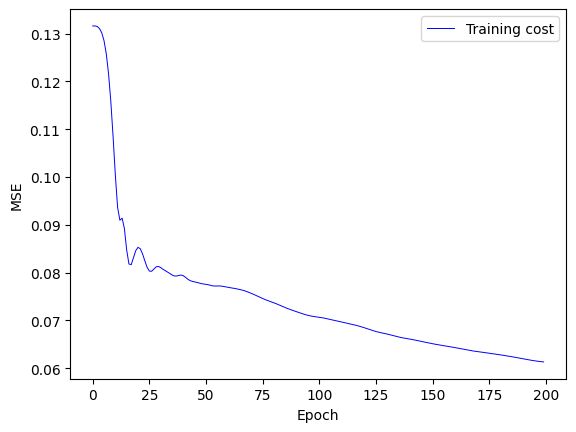

In [ ]:
import tensorflow as tf
from tqdm.keras import TqdmCallback
import time, datetime, IPython

# See the file 'tf-model.png' that was generated with a solution to this exercise - when you run
# your own implementation, you will get your own plot.
def create_model(k=50, lrate=.01, neg=4, nepochs=150):
    # 'users' is an input layer of type tf.int64.
    users = tf.keras.layers.Input(shape = (), dtype = tf.int64)
    user_embeddings = tf.keras.layers.Embedding(ratings.nusers, k, embeddings_initializer = tf.keras.initializers.RandomNormal(stddev = 1/ratings.nusers))(users) # Your code here...
    #user_drop = tf.keras.layers.Dropout(0.2)(user_embeddings)
    #users_dense = tf.keras.layers.Dense(30, activation = "relu", kernel_regularizer="l2")(user_drop)
    users_dense = tf.keras.layers.Dense(int(k*0.9), activation = "linear")(user_embeddings)


    # 'items' is an input layer of type tf.int64.
    items = tf.keras.layers.Input(shape = (), dtype = tf.int64)
    item_embeddings = tf.keras.layers.Embedding(ratings.nitems, k, embeddings_initializer = tf.keras.initializers.RandomNormal(stddev = 1/ratings.nitems))(items)
    #item_drop = tf.keras.layers.Dropout(0.2)(item_embeddings)
    #items_dense = tf.keras.layers.Dense(30, activation = "relu", kernel_regularizer="l2")(item_drop)
    items_dense = tf.keras.layers.Dense(int(k*0.9), activation = "linear")(item_embeddings)
    # TensorFlow has a built-in dot-product layer.
    dot = tf.keras.layers.Dot(axes = 1)([users_dense, items_dense])
    # Now we need a generic model that wraps up the "network", specifying the input and output layers.
    tf_mf = tf.keras.Model(inputs = [users, items], outputs = dot)
    # Compile the model: Adam optimizer is suggested here over SGD.
    # Your code here...
    tf_mf.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = lrate), loss = "MSE")

    # Show the model topology - a plot will be produced in a file 'tf-model.png'.
    tf_mf.summary()
    tf.keras.utils.plot_model(tf_mf, to_file='tf-model.png', show_shapes=True, dpi=150)

    hist = train_model(tf_mf, neg, nepochs)
    return tf_mf, hist

def train_model(tf_mf, neg, nepochs):
    # We inject 'neg' negative samples for every available rating in the training data
    nneg = neg * ratings.ntrain
    users = np.concatenate((ratings.train_df.u, np.random.randint(ratings.nusers, size=nneg)))
    items = np.concatenate((ratings.train_df.i, np.random.randint(ratings.nitems, size=nneg)))
    rs = ratings.train_matrix[users, items]
    batch_size = ratings.ntrain + nneg # Single batch with all the data at once.

    hist = tf_mf.fit([users, items], rs, batch_size = batch_size, epochs = nepochs, callbacks=[TqdmCallback(verbose=0)], verbose = 0) # Produces a prettier progress bar.
    return hist

# Create the model - this will directly trigger training.
tf.random.set_seed(0) # For comparability and debugging (the randomness here is in parameter initialization).
start_time = time.time()
tf_mf, hist = create_model(k=50, lrate=.005, nepochs=200)

# Plot the training error and report the test metric value (P@10).

plot(hist.history['loss'])

uexplode = np.full((ratings.nitems, ratings.nusers), np.arange(ratings.nusers)).T.flatten()
iexplode = np.full((ratings.nusers, ratings.nitems), np.arange(ratings.nitems)).flatten()
scores = tf_mf.predict([uexplode, iexplode], batch_size=ratings.nusers*100,
                       verbose=1).reshape(ratings.nusers, ratings.nitems)
p = precision(scores*(1-ratings.train_mask), ratings.test_matrix, 10)
trace(hist.params['epochs'], start_time, hist.history['loss'][-1], p, 'P@10')

Se han hecho pruebas también añadiendo dropout y regularización en las capas densas, de lo que no se han conseguido mejores resultados, por lo tanto no se han incluido en el informe